In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy

%matplotlib inline

## Extraer usuarios

In [2]:
# get users and mentions from the download files:
tweets_datas_path = [#'dwnld_debate.json',
                     #'dwnld_1.json',
                     'dwnld_2.json'#,
                     #'dwnld_3.json',
                     #'dwnld_4.json',
                     #'Raw_tweets_0.json',
                     #'Raw_tweets_1.json',
                     #'Raw_tweets_a.json'
                    ]             
# get users and mentions from the download files:
# tweets_datas_path = ['dwnld_debate.json',
#                      'dwnld_1.json',
#                      'dwnld_2.json',
#                      'dwnld_3.json',
#                      'dwnld_4.json',
#                      'Raw_tweets_0.json',
#                      'Raw_tweets_1.json',
#                      'Raw_tweets_a.json'
#                     ]                    
tw_id=[]
tw_user_id=[]
tw_user=[]
tw_text=[]
entities_long=[]
mentioned_ids=[]

for json_file in tweets_datas_path:
    with open(json_file, "r") as tweets_file:
        for line in tweets_file:
            try:
                tweet = json.loads(line)
                tw_entities=[]
                tw_entities.extend(tweet["entities"]["user_mentions"])
                entities_long.extend(tweet["entities"]["user_mentions"])
                tw_text_loop=[tweet["text"]]
                if tweet["truncated"]:#=="True": # Truncated indica si el tweet es corto o largo; si truncado, busca extendido
                    tw_text_loop=[tweet["extended_tweet"]["full_text"]]
                    tw_entities.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                    entities_long.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                else:
                    if tweet["text"][0:2]=="RT":
                        if tweet["retweeted_status"]["truncated"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                        else: 
                            tw_text_loop=[tweet["retweeted_status"]["text"]]
                            tw_entities.extend(tweet["retweeted_status"]["entities"]["user_mentions"])
                        if tweet["retweeted_status"]["is_quote_status"]:
                            tw_text_loop=[tweet["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                    else:
                        tw_text_loop=[tweet["text"]]
                tw_id.append(tweet["id_str"])
                tw_user_id.append(tweet["user"]["id_str"])
                tw_user.append(tweet["user"]["screen_name"])
                mentioned_ids.append([tweet["id_str"],tweet["user"]["id_str"],list(set([ent["id_str"] for ent in tw_entities]))])
                tw_text.append([tweet["id_str"],tw_text_loop])
            except:
                continue



In [3]:
print("Tweets identificados con código     :",len(tw_id),"\n",
      "Tweets con usuario identificado     :",len(tw_user_id),"\n",
      "Tweets con nombre de usuario        :",len(tw_user),"\n",
      "Textos de tweets recuperados        :",len(tw_text),"\n",
      "Total de Menciones en los tweets    :",len(entities_long),"\n",
      "Tweets con menciones identificadas  :",len(mentioned_ids),"\n"
)

Tweets identificados con código     : 829049 
 Tweets con usuario identificado     : 829049 
 Tweets con nombre de usuario        : 829049 
 Textos de tweets recuperados        : 829049 
 Total de Menciones en los tweets    : 4319019 
 Tweets con menciones identificadas  : 829049 



In [4]:
tweets_ids=pd.DataFrame({"tw_user_id":tw_user_id,"tw_user":tw_user}, index=tw_id)
ids_freqs=pd.crosstab(index=tweets_ids.tw_user, columns="count")
ids_freqs=ids_freqs.sort_values(by=['count'] , ascending=False)["count"]
print("twiteros:",ids_freqs.shape[0])

twiteros: 117841


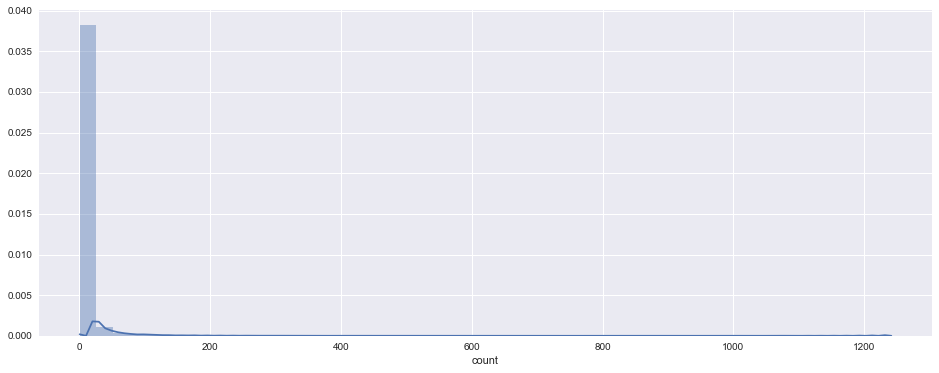

In [5]:
plt.figure(figsize=(16,6))
sns.distplot(ids_freqs)

In [6]:
round(ids_freqs.describe(),3)

count    117841.000
mean          7.035
std          23.319
min           1.000
25%           1.000
50%           2.000
75%           4.000
max        1241.000
Name: count, dtype: float64

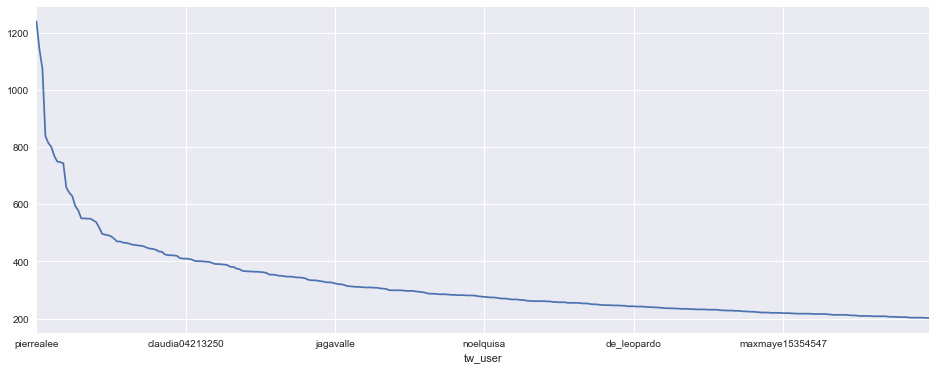

In [7]:
ids_freqs[:300].plot(figsize=(16, 6))

In [8]:
ids_freqs.sort_values(ascending=False)[:60]

tw_user
pierrealee         1241
Cmarcafederal      1143
jaramillo_diana    1076
AbCarrymar          839
AlexisSCol          815
PORMIPATRIAYA       801
GusDuque1           769
abel3131            750
TWITERM99417410     748
NANACHAGU           744
nenoriega5          659
CarrillonavasG      641
valderramaangel     629
waltermunevar       594
VictoriaRubian5     579
SenorCaicedo        551
cesar_garcia_nt     551
marco_caldon        550
juansex11151175     550
MejorBogotaGVL      544
dinirro             538
Monyrica            519
josecastano0904     497
lguzmangomez        494
jjolivella          492
Amparoc66           488
anibalac071         480
macdonal5           470
GPATTYVT            470
ceciliamr1948       466
Gustavo68831299     465
krlosgiraldo1       463
MejorCundinamar     459
RenovablesUniv1     458
RaquelN57315659     456
Caldasllerista      455
Monajaneth          453
AlfredoNobel1       448
EricTamaroL         445
ArturoSin5          444
Sachaka7            441
lugicas 

In [9]:
ids_freqs.to_csv("freqs_tweets.csv")

In [10]:
uniq_ids=list(set([entit["id_str"]for entit in entities_long]))
len(uniq_ids)

43721

In [11]:
ments_df=pd.DataFrame([[entit["id_str"],
                        entit["screen_name"],
                        entit["name"]
                       ]for entit in entities_long],
                     columns=["id_str","screen_name","name"])

In [12]:
ments_freq=pd.crosstab(index=ments_df.screen_name, columns="count")
ments_freq=ments_freq.sort_values(by=['count'] , ascending=False)
print("Cuentas mencionadas",ments_freq.shape[0])

Cuentas mencionadas 43845


### Clustering Candidatos

In [13]:
scr_nm_cands=["DeLaCalleHum", "ClaraLopezObre",
              "MoralesViviane",
              "sergio_fajardo","ClaudiaLopez",
              "VotoenblancoCo",
              "piedadcordoba","JaimeAraujoR",
              "prjorgetrujillo",
              "German_Vargas","PinzonBueno",
              "IvanDuque","mluciaramirez",
              "petrogustavo","angelamrobledo"
              ]

#[ments_df.loc[ments_df.screen_name==nm_cand].iloc[0:1,0] for nm_cand in scr_nm_cands]
id_str_cand=["823348278830002177","126832572",
             "86622012",
             "25185308","137908875",
             "910144193586188288",
             "34798360","2542586322",
             "232344683",
             "20456814","3401638840",
             "77653794","198984928",
             "49849732","165748292"
             ]

cands_mntns=np.array([[cand in tw_mntns[2] for cand in id_str_cand]for tw_mntns in mentioned_ids])
cands_mntns.shape


(829049, 15)

In [14]:
df_cands_mntns=pd.DataFrame(cands_mntns,columns=scr_nm_cands)

petrogustavo       356382
IvanDuque          354136
sergio_fajardo      80921
DeLaCalleHum        74696
German_Vargas       64812
mluciaramirez       47043
ClaudiaLopez        23320
angelamrobledo      22265
PinzonBueno         10881
piedadcordoba        2943
MoralesViviane       2884
ClaraLopezObre       1931
JaimeAraujoR           20
prjorgetrujillo        11
VotoenblancoCo          5
dtype: int64


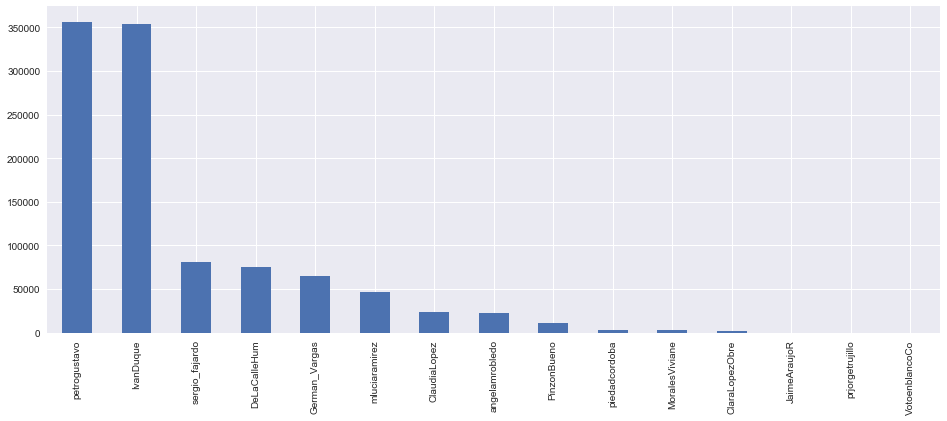

In [15]:
plt.figure(figsize=(16,6))
print (df_cands_mntns.sum(axis=0).sort_values(ascending=False))
df_cands_mntns.sum(axis=0).sort_values(ascending=False).plot(kind="bar")

In [16]:
# plt.figure(figsize=(15,12))
# plt.imshow(df_cands_mntns.iloc[:25,:], cmap=plt.cm.gray_r, interpolation='nearest')

In [17]:
cands_ward= hierarchy.linkage(df_cands_mntns.transpose(), 'ward')

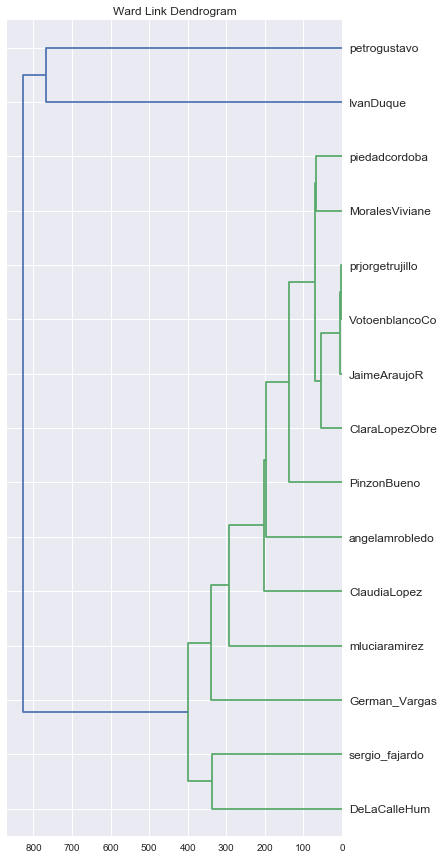

In [18]:
#max_d = 10
plt.figure(figsize=(6,15))
#plt.figure()
dn = hierarchy.dendrogram(cands_ward,orientation="left", labels=scr_nm_cands)
#plt.axhline(y=max_d, c='k')
plt.title('Ward Link Dendrogram')
plt.savefig('cands_dendrograma_ward.png')
plt.show()

### Clustering Nexos

In [19]:
# Tabla de ocurrencia de menciones por tuit
id_ments=pd.crosstab(np.array([tw_mnt for tw_mntns in mentioned_ids for tw_mnt in tw_mntns[2] ]), columns="count").sort_values(ascending=False, by="count")

In [20]:
top_n=300

In [21]:
ments_ids_top=list(id_ments.index[:top_n])

In [22]:
mntns_top_ocurr=np.array([[cand in tw_mntns[2] for cand in ments_ids_top]for tw_mntns in mentioned_ids])

In [23]:
mntns_top_ocurr.shape

(829049, 300)

In [24]:
names_mnts_top=[]
for usr_id in id_ments.index[:top_n]:
    name=""
    try:
        name=ments_df[ments_df.id_str==usr_id].screen_name.iloc[0]
    except:
        name="Unknown"
#     print(usr_id, name)
    names_mnts_top.append(name)
        
#     print(usr_id,tweets_ids[tweets_ids.tw_user_id==usr_id].tw_user.iloc[0])

In [25]:
twtxt_ids=[txt_id[0] for txt_id in tw_text] # Id del tuit con el texto
df_mntns_top_ocurr=pd.DataFrame(mntns_top_ocurr,columns=names_mnts_top, index=twtxt_ids)

petrogustavo       356382
IvanDuque          354136
sergio_fajardo      80921
DeLaCalleHum        74696
German_Vargas       64812
AlvaroUribeVel      51881
mluciaramirez       47043
CeDemocratico       34851
ClaudiaLopez        23320
HOLLMANMORRIS       23189
angelamrobledo      22265
OIZuluaga           16985
GustavoBolivar      16302
RevistaSemana       14124
ColombiaHumana_     13769
NoticiasCaracol     13746
MejorVargasLle      13231
JuanManSantos       12062
matadoreltiempo     11871
PinzonBueno         10881
dtype: int64


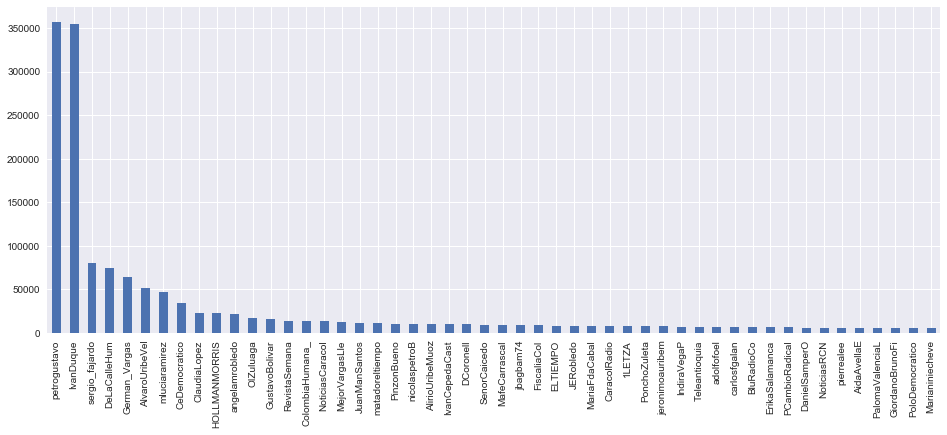

In [26]:
plt.figure(figsize=(16,6))
print (df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig('top_mentions.png')

In [27]:
mntns_ward= hierarchy.linkage(df_mntns_top_ocurr.transpose(), 'ward')

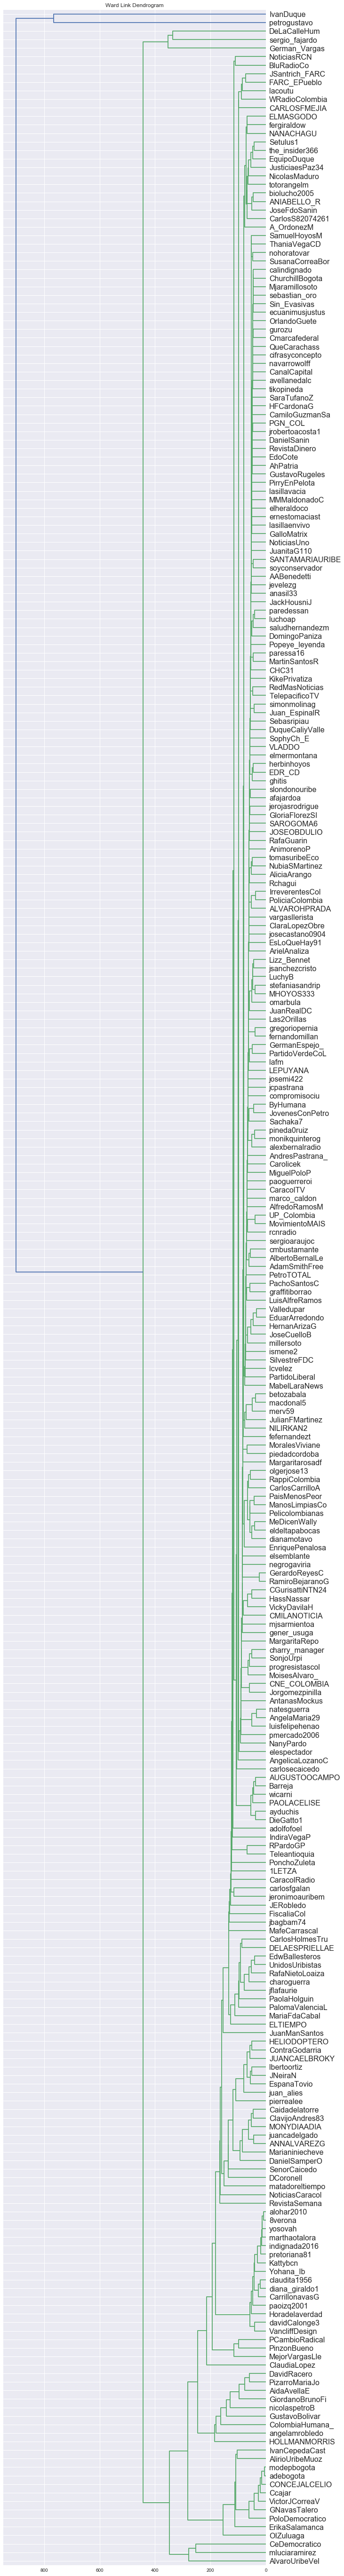

In [28]:
#max_d = 10
plt.figure(figsize=(10,100))
#plt.figure()
dn = hierarchy.dendrogram(mntns_ward,orientation="left", labels=names_mnts_top)
#plt.axhline(y=max_d, c='k')
plt.title('Ward Link Dendrogram')
plt.yticks(fontsize=16)
plt.savefig('dendrograma_ward_link_mentions.png')
plt.show()